In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

from utils_plot import get_predefined_color_labels, plotDicts, abbreviateValue

from run_pruned_v2 import run_pruning_experiment


In [3]:
type_criterions = [ 'divergence_criterion', 'entropy']
output_dir = 'output_results_01_05'



min_support_tree = 0.1
min_sup_divergences = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2]

saveFig = False

size_fig = (3,3)

In [4]:

def _rename_dataset(name):
    if name  =='artificial_gaussian': 
        return 'synt.-peak' 
    if name == 'online_shoppers_intention':
        return 'intentions'
    if name == 'bank-full':
        return 'bank'
    return name



In [5]:
results_all = {}

In [6]:
        
abbreviations = {"one_at_time":"indiv t.", \
                        "divergence_criterion":"g$\\Delta$", "entropy":"entr", 'pruned': '- pruned'}



color_labels = get_predefined_color_labels(abbreviations)
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

In [7]:
output_fig_dir = os.path.join(os.path.curdir, output_dir, "figures", 'comparisons')

In [8]:
saveFig = True

if saveFig:
    from pathlib import Path

    Path(output_fig_dir).mkdir(parents=True, exist_ok=True)

In [9]:
type_gens = ['generalized']
datasets = ['adult', 'artificial_gaussian', 'compas', 'german', 'online_shoppers_intention', 'wine', 'bank-full']
metrics = ['d_error', 'd_error', 'd_fpr', 'd_error', 'd_error', 'd_error', 'd_error']
colors_for_dataset_all = ["#EE552F", '#B574E8', '#5C72CD', '#5CCDAE', '#bdbdbd', '#88246a', '#EEDB6E']
colors_for_dataset_pruned = ["#BF4425", '#9846D7', '#2e4193', '#277e66', '#7a7878', '#551642', '#DABE21']

pruning_names = ['_pruned', '']
type_criterion = 'divergence_criterion'



In [10]:
color_labels = {}

 
for dataset_name, color_all, color_pruned in zip(datasets, colors_for_dataset_all[:len(datasets)], colors_for_dataset_pruned[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color_all  
            
        for pruning_type in pruning_names:
            color = color_all if pruning_type == '' else color_pruned
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}{pruning_type}', abbreviations)]=color

            
lines_style = {k:"-" for k in color_labels}
#lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
#lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

#lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("entropy", abbreviations) in k and abbreviations["entropy"] in k)})

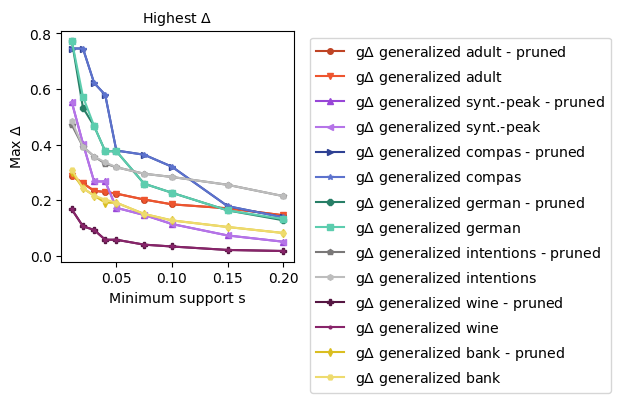

In [11]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)
    

    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for pruning_type in  pruning_names:
        if pruning_type in results:
            for sup in sorted(results[pruning_type].keys()):
                for type_gen in type_gens:
                    config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}{pruning_type}", abbreviations)
                    if config_key not in info_plot:
                        info_plot[config_key] = {}
                    type_gen_str = type_gen+pruning_type
                    info_plot[config_key][float(sup)] = results[pruning_type][sup][type_gen_str]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta$"
        title=f"Highest $\\Delta$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    figure_name = os.path.join(output_fig_dir, f"stree_{min_support_tree}_max_div_pruning.pdf")

    
size_fig = (3, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=False, nameFig = figure_name, legendSize=10.2)
            




# Plot (v1)

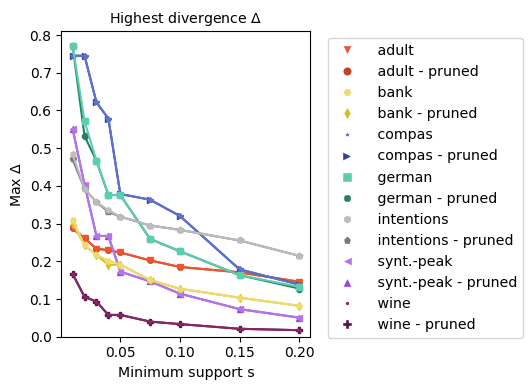

In [12]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit=(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=10.2
markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False
yscale="linear"
legendSize=10.2
saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

size_fig = (5.5,4)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=size_fig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if marker:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=MARKERS[m_i],
            linewidth=linewidth,
            markersize=markersize,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
        m_i = m_i + 1
    else:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)



plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i]]
#handles = [handles[i] for i in idxs]
legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

# Difference

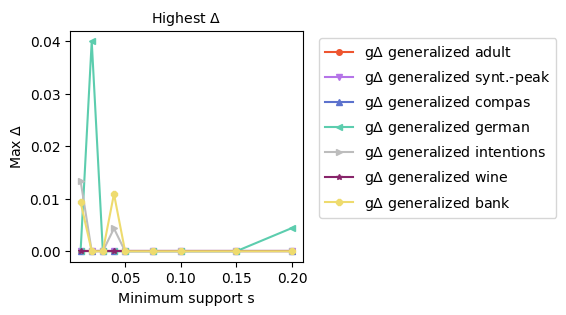

In [13]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)


    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for pruning_type in  pruning_names:
        if pruning_type in results:
            for sup in sorted(results[pruning_type].keys()):
                for type_gen in type_gens:
                    config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}", abbreviations)
                    if config_key not in info_plot:
                        info_plot[config_key] = {}
                    type_gen_str = type_gen+pruning_type
                    if float(sup) not in info_plot[config_key]:
                        info_plot[config_key][float(sup)] = 0
                    if pruning_type == '':
                        info_plot[config_key][float(sup)]+= results[pruning_type][sup][type_gen_str]
                    else:                        
                        info_plot[config_key][float(sup)]-= results[pruning_type][sup][type_gen_str]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta$"
        title=f"Highest $\\Delta$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    figure_name = os.path.join(output_fig_dir, f"stree_{min_support_tree}_max_div_pruning.pdf")

    
size_fig = (3, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=False, nameFig = figure_name, legendSize=10.2)
            




In [14]:
for k in info_plot:
    for s in info_plot[k]:
        if info_plot[k][s]!=0:
            print(k, s, info_plot[k][s])

g$\Delta$ generalized german 0.02 0.040000000000000036
g$\Delta$ generalized german 0.2 0.0044203426904849685
g$\Delta$ generalized intentions 0.01 0.013395348837209164
g$\Delta$ generalized intentions 0.04 0.004333883667767324
g$\Delta$ generalized bank 0.01 0.009339080459770055
g$\Delta$ generalized bank 0.04 0.01091646690023973


# Plot (v2 - paper)

In [15]:
color_labels = {}

 
for dataset_name, color_all, color_pruned in zip(datasets, colors_for_dataset_all[:len(datasets)], colors_for_dataset_pruned[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color_all  
            
        for pruning_type in pruning_names:
            color = color_all if pruning_type == '' else color_pruned
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}{pruning_type}', abbreviations)]=color

In [16]:
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("entropy", abbreviations) in k and abbreviations["entropy"] in k)})

adult
artificial_gaussian
compas
german
online_shoppers_intention
wine
bank-full


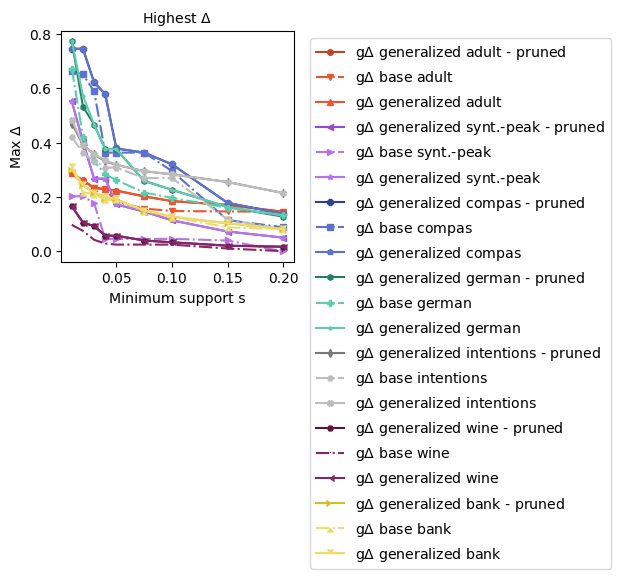

In [17]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)
    
    print(dataset_name_file)
        
    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            

            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for pruning_type in  pruning_names:
        if pruning_type in results:
            for sup in sorted(results[pruning_type].keys()):
                for type_gen in ['base', 'generalized']:
                    if type_gen == 'base' and pruning_type=='_pruned':
                        continue
                    config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}{pruning_type}", abbreviations)
                    if config_key not in info_plot:
                        info_plot[config_key] = {}
                    type_gen_str = type_gen+pruning_type
                    info_plot[config_key][float(sup)] = results[pruning_type][sup][type_gen_str]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta$"
        title=f"Highest $\\Delta$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    figure_name = os.path.join(output_fig_dir, f"stree_{min_support_tree}_max_div_pruning.pdf")

    
size_fig = (3, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=False, nameFig = figure_name, legendSize=10.2)
            





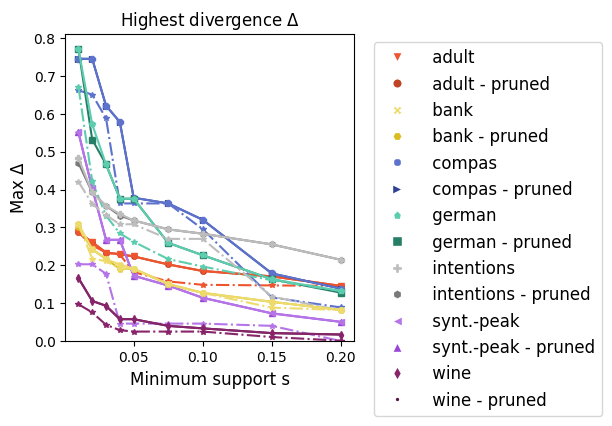

In [18]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit=(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=12
markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False
yscale="linear"
legendSize=12
saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

size_fig = (6.3,4.2)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=size_fig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=marker_i,
            linewidth=linewidth,
            markersize=markersize,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
        
    else:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)



plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison_vs_base.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

In [19]:
nameFig

'./output_results_01_05/figures/comparisons/heuristic_comparison_vs_base.pdf'

# Time

In [20]:
color_labels = {}

 
for dataset_name, color_all, color_pruned in zip(datasets, colors_for_dataset_all[:len(datasets)], colors_for_dataset_pruned[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color_all  
            
        for pruning_type in pruning_names:
            color = color_all if pruning_type == '' else color_pruned
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}{pruning_type}', abbreviations)]=color

In [21]:
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"--" for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("entropy", abbreviations) in k and abbreviations["entropy"] in k)})

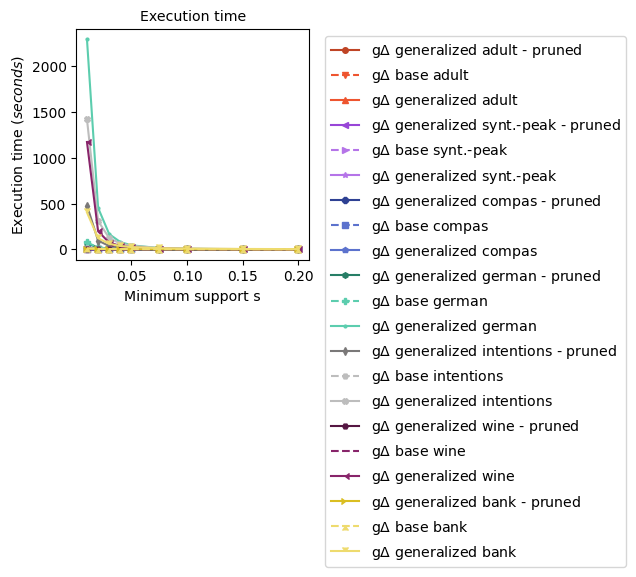

In [22]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)
    

    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i ='time' 
    results = results_all[dataset_name][info_i]

    for pruning_type in  pruning_names:
        if pruning_type in results:
            for sup in sorted(results[pruning_type].keys()):
                for type_gen in [ 'base', 'generalized']:
                    if type_gen == 'base' and pruning_type=='_pruned':
                        continue
                    config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}{pruning_type}", abbreviations)
                    if config_key not in info_plot:
                        info_plot[config_key] = {}
                    type_gen_str = type_gen+pruning_type
                    info_plot[config_key][float(sup)] = results[pruning_type][sup][type_gen_str]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta$"
        title=f"Highest $\\Delta$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    figure_name = os.path.join(output_fig_dir, f"stree_{min_support_tree}_max_div_pruning.pdf")

    
size_fig = (3, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=False, nameFig = figure_name, legendSize=10.2)
            





In [23]:
min_v = min([info_dicts[k][0.2] for k in info_dicts])
max_v = min([info_dicts[k][0.01] for k in info_dicts if 0.01 in info_dicts[k] ])

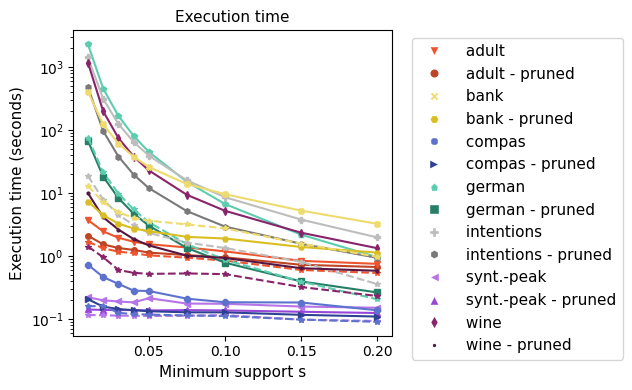

In [24]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(min_v, max_v) #(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=11
legendSize=11

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel= 'Execution time (seconds)'
title= 'Execution time'

import matplotlib.pyplot as plt
import numpy as np

size_fig = (6.5,4)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=size_fig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    #if 'pruned' not in label_name:
    #    if 'base' not in label_name:
    #        continue
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=marker_i,
            linewidth=linewidth,
            markersize=markersize,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
        
    else:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

    
yscale="log"



if limit is not None:
    if yscale == 'log':
        import math
        to_log = lambda x: math.log(x) if x!=None else None
        #limit = (to_log(limit[0]), to_log(limit[1]))
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)




plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison_vs_base.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

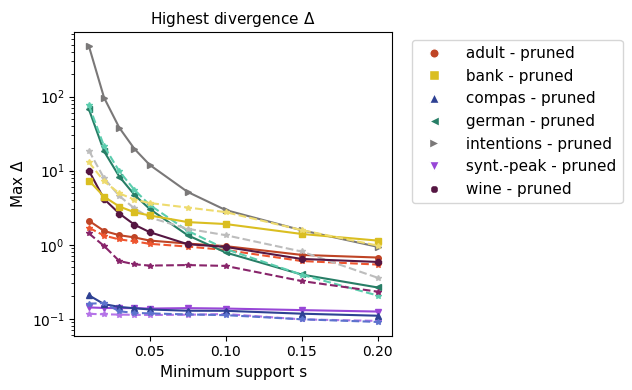

In [25]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=11
legendSize=11

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

size_fig = (6.5,4)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=size_fig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if 'pruned' not in label_name:
        if 'base' not in label_name:
            continue
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=marker_i,
            linewidth=linewidth,
            markersize=markersize,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
        
    else:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)


yscale="log"


plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison_vs_base.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

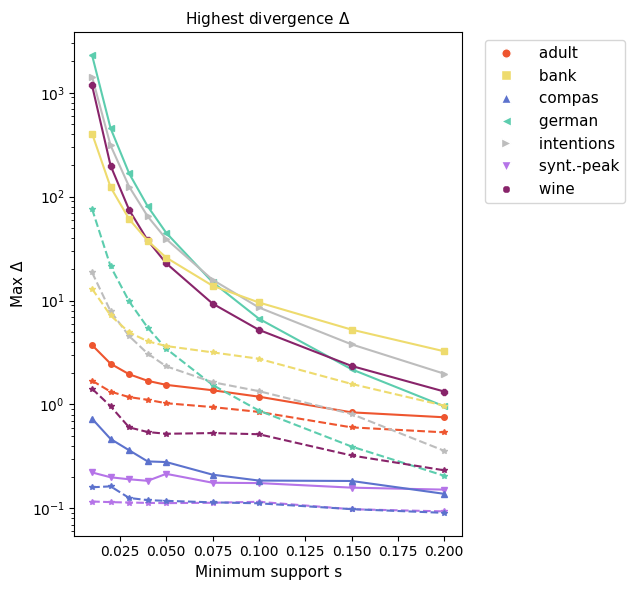

In [26]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=11
legendSize=11

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

size_fig = (6.5,6)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=size_fig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if 'pruned' in label_name:
        continue
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=marker_i,
            linewidth=linewidth,
            markersize=markersize,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
        
    else:
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            color=colors[e],
            linestyle=linestyle[label_name],
        )
import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)


yscale="log"


plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison_vs_base.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

# Paper

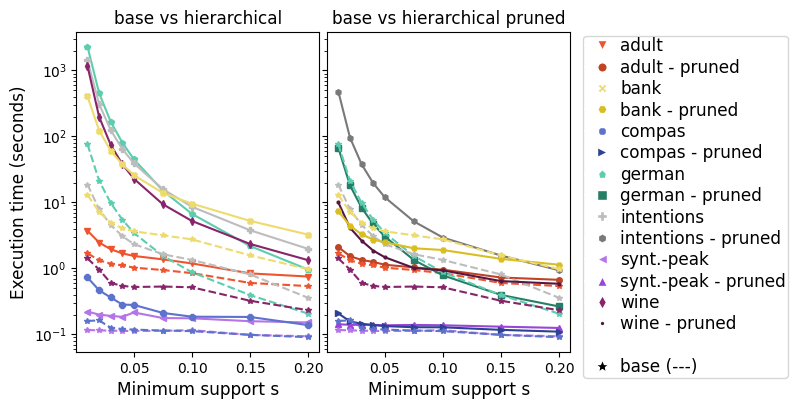

In [27]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"
sizeFig=(3, 3)
labelSize=12.2
legendSize=12.2

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Execution time (seconds)"
title1=f"base vs hierarchical"
title2=f"base vs hierarchical pruned"

import matplotlib.pyplot as plt
import numpy as np

size_fig = (7.8,3.9)

# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size_fig, dpi=100, sharey = True, constrained_layout = True)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'


markers = {}
m_i = 0
for label_name in info_dicts:
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i

for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    
    if 'pruned' in label_name:
        axs = [ax2]
    elif 'base' in label_name:
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    
    for ax in axs:
        ax.plot(
                list(info_dict.keys()),
                list(info_dict.values()),
                label=label_name,
                marker=markers[label_name] if marker else None,
                linewidth=linewidth,
                markersize=markersize if marker else None,
                color=colors[e],
                linestyle=linestyle[label_name],
            )

import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

ax1.set_xlabel(xlabel, fontsize=labelSize)
ax2.set_xlabel(xlabel, fontsize=labelSize)
ax1.set_ylabel(ylabel, fontsize=labelSize)
ax1.set_title(title1, fontsize=labelSize)
ax2.set_title(title2, fontsize=labelSize)

yscale="log"


plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


handles = handles + handles2
labels = labels + labels2

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Line',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
i = idxs[0]
legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'white', markersize=handles[i]._markersize*2.5))


legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'black', markersize=handles[i]._markersize*2.5))

labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')[1:] for i in idxs]
labels.append("")

labels.append(r'base (---)')



outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        labelspacing=0.2,
        columnspacing=0.2,
        fontsize=5,
        title_fontsize=5,
        borderaxespad = 0.2,
               borderpad = 0.1,
               handletextpad = 0.1
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        columnspacing=0.2,
        borderpad=borderpad,
    ) 

    
    
nameFig = os.path.join(output_fig_dir, 'heuristic_comparison_vs_base_time.pdf') 
if saveFig:
    fig.tight_layout(pad = 0.03)
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

# Plot divergence and time

In [28]:
abbreviations = {'one_at_time': 'indiv t.',
 'divergence_criterion': 'g$\\Delta$',
 'entropy': 'entr',
 'pruned': 'pr.'}

In [29]:
color_labels = {}

 
for dataset_name, color_all, color_pruned in zip(datasets, colors_for_dataset_all[:len(datasets)], colors_for_dataset_pruned[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color_all  
            
        for pruning_type in pruning_names:
            color = color_all if pruning_type == '' else color_pruned
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}{pruning_type}', abbreviations)]=color

In [30]:
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"--" for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("entropy", abbreviations) in k and abbreviations["entropy"] in k)})

In [31]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot_div = {}
info_plot_time = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)
    

    results_all[dataset_name] = {'time':{}, 'fp': {}, 'max_div' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name]['max_div' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    for info_plot, info_i in [(info_plot_div, 'max_div'), (info_plot_time, 'time')]:
        results = results_all[dataset_name][info_i]

        for pruning_type in  pruning_names:
            if pruning_type in results:
                for sup in sorted(results[pruning_type].keys()):
                    for type_gen in [ 'base', 'generalized']:
                        if type_gen == 'base' and pruning_type=='_pruned':
                            continue
                        config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}{pruning_type}", abbreviations)
                        if config_key not in info_plot:
                            info_plot[config_key] = {}
                        type_gen_str = type_gen+pruning_type
                        info_plot[config_key][float(sup)] = results[pruning_type][sup][type_gen_str]


        for type_gen_str in info_plot:
            info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))

In [32]:
min_v_time = min([info_plot_time[k][0.2] for k in info_plot_time])
max_v_time = min([info_plot_time[k][0.01] for k in info_plot_time if 0.01 in info_plot_time[k] ])

# Paper

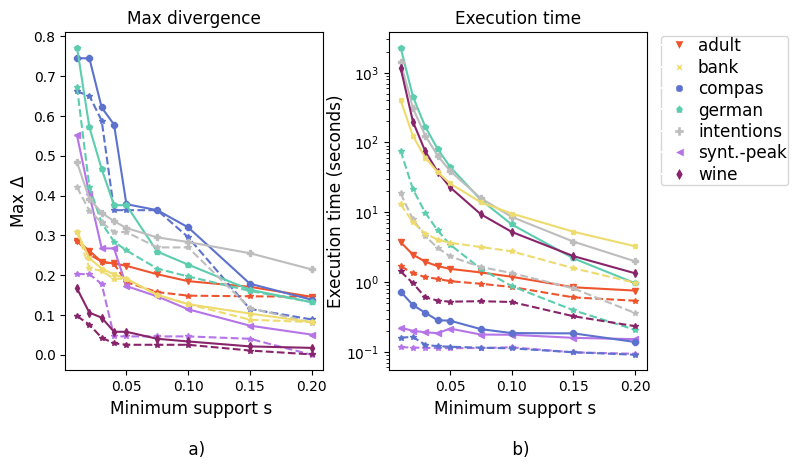

In [33]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"

labelSize=12.2
legendSize=12.2

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel1 = "Minimum support s \n\n a)"
xlabel2 = "Minimum support s \n \n b)"
ylabel1 = "Max $\\Delta$"
ylabel2 = f"Execution time (seconds)"
title1 = f"Max divergence"
title2 = f"Execution time"

import matplotlib.pyplot as plt
import numpy as np

outside = True

if outside:
    size_fig = (7.8, 4.5)
else:
    size_fig = (6.8, 4.5)


# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size_fig, dpi=100, constrained_layout = True)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

MARKERS[13] = "<"



markers = {}
m_i = 0
for label_name in info_dicts:
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i

for ax, info_dicts in [(ax1, info_plot_div), (ax2, info_plot_time)]:

    
    for e, (label_name, info_dict) in enumerate(info_dicts.items()):
        if 'pr.' in label_name:
            continue
            
            
        ax.plot(
                list(info_dict.keys()),
                list(info_dict.values()),
                label=label_name,
                marker=markers[label_name] if marker else None,
                linewidth=linewidth,
                markersize=(markersize if markers[label_name]!='X' else markersize*0.8) if marker else None,
                color=colors[e],
                linestyle=linestyle[label_name],
            )

import cycler


if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

ax1.set_xlabel(xlabel1, fontsize=labelSize)
ax2.set_xlabel(xlabel2, fontsize=labelSize)
ax1.set_ylabel(ylabel1, fontsize=labelSize)
ax2.set_ylabel(ylabel2, fontsize=labelSize, labelpad=1)
ax1.set_title(title1, fontsize=labelSize)
ax2.set_title(title2, fontsize=labelSize)


ax2.yaxis.labelpad = 1

ax2.yaxis.tickspad = 1

yscale="log"


plt.xscale(xscale)
if not kformat:
    ax2.set_yscale(yscale)
    
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles + handles2
labels = labels + labels2

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Line',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]

labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')[1:] for i in idxs]

idxs = [i for i in range(len(labels)) if (i+1)== len(labels) or labels[i]!=labels[i+1] ]

labels = [labels[i] for i in idxs]
legend_handles = [legend_handles[i] for i in idxs]

"""
i = idxs[0]
legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'white', markersize=handles[i]._markersize*2.5))


legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'black', markersize=handles[i]._markersize*2.5))


labels.append("")

labels.append(r'base (---)')
"""


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        labelspacing=0.2,
        columnspacing=0.2,
        fontsize=5,
        title_fontsize=5,
        borderaxespad = 0.2,
               borderpad = 0.1,
               handletextpad = 0.1
    )
else:
    for ax in [ax1, ax2]:
        ax.legend(handles = legend_handles, labels = labels,
            prop={"size": legendSize},
            title=titleLegend,
            fontsize=legendSize,
            title_fontsize=legendSize,
            labelspacing=0.2,
            columnspacing=0.2,
            borderpad=borderpad,
        ) 

    
if outside:
    outside_str = '_outside'
else:
    outside_str = ''
nameFig = os.path.join(output_fig_dir, f'generalized_vs_base_div_time{outside_str}.pdf') 
if saveFig:
    fig.tight_layout(pad = 0.03)
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

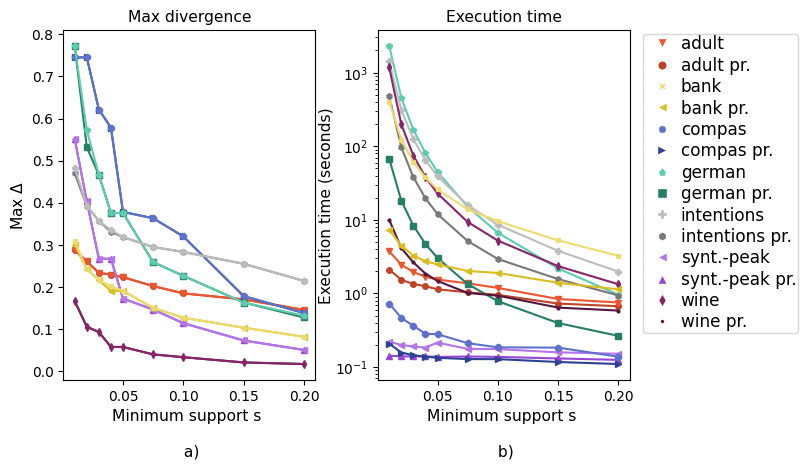

In [34]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"

labelSize = 11.2
legendSize=12.2

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel1 = "Minimum support s \n\n a)"
xlabel2 = "Minimum support s \n \n b)"
ylabel1 = "Max $\\Delta$"
ylabel2 = f"Execution time (seconds)"
title1 = f"Max divergence"
title2 = f"Execution time"

import matplotlib.pyplot as plt
import numpy as np

outside = True

if outside:
    size_fig = (7.9, 4.5) #(7.8, 4.5)
else:
    size_fig = (6.8, 4.5)


# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size_fig, dpi=100, constrained_layout = True)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

MARKERS[13] = "<"

markers = {}
m_i = 0
for label_name in info_dicts:
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i

for ax, info_dicts in [(ax1, info_plot_div), (ax2, info_plot_time)]:

    
    for e, (label_name, info_dict) in enumerate(info_dicts.items()):
        if 'base' in label_name:
            continue
            
        ax.plot(
                list(info_dict.keys()),
                list(info_dict.values()),
                label=label_name,
                marker=markers[label_name] if marker else None,
                linewidth=linewidth,
                markersize=(markersize if markers[label_name]!='X' else markersize*0.8) if marker else None,
                color=colors[e],
                linestyle=linestyle[label_name],
            )

import cycler


if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

ax1.set_xlabel(xlabel1, fontsize=labelSize)
ax2.set_xlabel(xlabel2, fontsize=labelSize)
ax1.set_ylabel(ylabel1, fontsize=labelSize)
ax2.set_ylabel(ylabel2, fontsize=labelSize, labelpad=1)
ax1.set_title(title1, fontsize=labelSize)
ax2.set_title(title2, fontsize=labelSize)


ax2.yaxis.labelpad = 1

ax2.yaxis.tickspad = 1

yscale="log"


plt.xscale(xscale)
if not kformat:
    ax2.set_yscale(yscale)
    
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles + handles2
labels = labels + labels2



idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Line',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7 )
                      for i in idxs]

labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')[1:] for i in idxs]


idxs = [i for i in range(len(labels)) if (i+1)== len(labels) or labels[i]!=labels[i+1] ]

labels = [labels[i] for i in idxs]
legend_handles = [legend_handles[i] for i in idxs]
"""


i = idxs[0]
legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'white', markersize=handles[i]._markersize*2.5))


legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'black', markersize=handles[i]._markersize*2.5))


labels.append("")

labels.append(r'base (---)')
"""


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        labelspacing=0.2,
        columnspacing=0.2,
        fontsize=5,
        title_fontsize=5,
        borderaxespad = 0.2,
               borderpad = 0.1,
               handletextpad = 0.1
    )
else:
    for ax in [ax1, ax2]:
        ax.legend(handles = legend_handles, labels = labels,
            prop={"size": legendSize},
            title=titleLegend,
            fontsize=legendSize,
            title_fontsize=legendSize,
            labelspacing=0.2,
            columnspacing=0.2,
            borderpad=borderpad,
        ) 

    
if outside:
    outside_str = '_outside'
else:
    outside_str = ''
nameFig = os.path.join(output_fig_dir, f'heuristic_comparison_vs_overall_div_time{outside_str}.pdf') 
if saveFig:
    fig.tight_layout(pad = 0.03)
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

# Plot divergence and time - v3

In [35]:
abbreviations = {'one_at_time': 'indiv t.',
 'divergence_criterion': 'g$\\Delta$',
 'entropy': 'entr',
 'pruned': 'pr.'}

In [36]:
type_gens = ['generalized']
datasets = ['adult', 'artificial_gaussian', 'compas', 'german', 'online_shoppers_intention', 'wine', 'bank-full']
metrics = ['d_error', 'd_error', 'd_fpr', 'd_error', 'd_error', 'd_error', 'd_error']
colors_for_dataset_all = ["#EE552F", '#B574E8', '#5C72CD', '#5CCDAE', '#bdbdbd', '#88246a', '#EEDB6E']
colors_for_dataset_pruned = ["#BF4425", '#9846D7', '#2e4193', '#277e66', '#7a7878', '#551642', '#DABE21']

pruning_names = ['_pruned', '']
type_criterion = 'divergence_criterion'




In [37]:
color_labels

{'g$\\Delta$ base adult': '#EE552F',
 'g$\\Delta$ base adult pr.': '#BF4425',
 'g$\\Delta$ generalized adult': '#EE552F',
 'g$\\Delta$ generalized adult pr.': '#BF4425',
 'g$\\Delta$ base synt.-peak': '#B574E8',
 'g$\\Delta$ base synt.-peak pr.': '#9846D7',
 'g$\\Delta$ generalized synt.-peak': '#B574E8',
 'g$\\Delta$ generalized synt.-peak pr.': '#9846D7',
 'g$\\Delta$ base compas': '#5C72CD',
 'g$\\Delta$ base compas pr.': '#2e4193',
 'g$\\Delta$ generalized compas': '#5C72CD',
 'g$\\Delta$ generalized compas pr.': '#2e4193',
 'g$\\Delta$ base german': '#5CCDAE',
 'g$\\Delta$ base german pr.': '#277e66',
 'g$\\Delta$ generalized german': '#5CCDAE',
 'g$\\Delta$ generalized german pr.': '#277e66',
 'g$\\Delta$ base intentions': '#bdbdbd',
 'g$\\Delta$ base intentions pr.': '#7a7878',
 'g$\\Delta$ generalized intentions': '#bdbdbd',
 'g$\\Delta$ generalized intentions pr.': '#7a7878',
 'g$\\Delta$ base wine': '#88246a',
 'g$\\Delta$ base wine pr.': '#551642',
 'g$\\Delta$ generalized w

In [38]:
color_labels = {}

 
for dataset_name, color_all in zip(datasets, colors_for_dataset_all[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color_all  
            
        for pruning_type in pruning_names:
            color = color_all 
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}{pruning_type}', abbreviations)]=color

In [39]:
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"--" for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("pruned", abbreviations) in k)})

In [40]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot_div = {}
info_plot_time = {}



for dataset_name_file, metric in zip(datasets, metrics):
    
    dataset_name = _rename_dataset(dataset_name_file)
    

    results_all[dataset_name] = {'time':{}, 'fp': {}, 'max_div' :{}}
    for pruning_type in pruning_names:
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][pruning_type] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name]['max_div' ][pruning_type] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    for info_plot, info_i in [(info_plot_div, 'max_div'), (info_plot_time, 'time')]:
        results = results_all[dataset_name][info_i]

        for pruning_type in  pruning_names:
            if pruning_type in results:
                for sup in sorted(results[pruning_type].keys()):
                    for type_gen in [ 'base', 'generalized']:
                        if type_gen == 'base' and pruning_type=='_pruned':
                            continue
                        config_key = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}{pruning_type}", abbreviations)
                        if config_key not in info_plot:
                            info_plot[config_key] = {}
                        type_gen_str = type_gen+pruning_type
                        info_plot[config_key][float(sup)] = results[pruning_type][sup][type_gen_str]


        for type_gen_str in info_plot:
            info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))

In [41]:
min_v_time = min([info_plot_time[k][0.2] for k in info_plot_time])
max_v_time = min([info_plot_time[k][0.01] for k in info_plot_time if 0.01 in info_plot_time[k] ])

# Paper

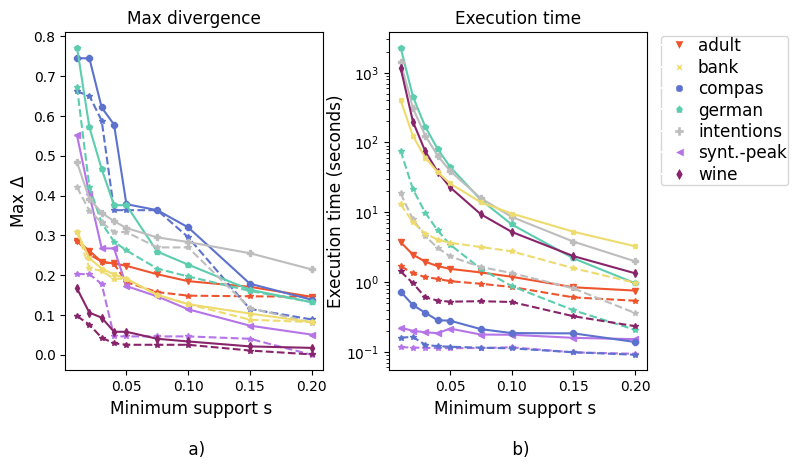

In [42]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"

labelSize=12.2
legendSize=12.2

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel1 = "Minimum support s \n\n a)"
xlabel2 = "Minimum support s \n \n b)"
ylabel1 = "Max $\\Delta$"
ylabel2 = f"Execution time (seconds)"
title1 = f"Max divergence"
title2 = f"Execution time"

import matplotlib.pyplot as plt
import numpy as np

outside = True

if outside:
    size_fig = (7.8, 4.5)
else:
    size_fig = (6.8, 4.5)


# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size_fig, dpi=100, constrained_layout = True)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

MARKERS[13] = "<"



markers = {}
m_i = 0
for label_name in info_dicts:
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i

for ax, info_dicts in [(ax1, info_plot_div), (ax2, info_plot_time)]:

    
    for e, (label_name, info_dict) in enumerate(info_dicts.items()):
        if 'pr.' in label_name:
            continue
            
            
        ax.plot(
                list(info_dict.keys()),
                list(info_dict.values()),
                label=label_name,
                marker=markers[label_name] if marker else None,
                linewidth=linewidth,
                markersize=(markersize if markers[label_name]!='X' else markersize*0.8) if marker else None,
                color=colors[e],
                linestyle=linestyle[label_name],
            )

import cycler


if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

ax1.set_xlabel(xlabel1, fontsize=labelSize)
ax2.set_xlabel(xlabel2, fontsize=labelSize)
ax1.set_ylabel(ylabel1, fontsize=labelSize)
ax2.set_ylabel(ylabel2, fontsize=labelSize, labelpad=1)
ax1.set_title(title1, fontsize=labelSize)
ax2.set_title(title2, fontsize=labelSize)


ax2.yaxis.labelpad = 1

ax2.yaxis.tickspad = 1

yscale="log"


plt.xscale(xscale)
if not kformat:
    ax2.set_yscale(yscale)
    
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles + handles2
labels = labels + labels2

idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('base', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Line',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]

labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')[1:] for i in idxs]

idxs = [i for i in range(len(labels)) if (i+1)== len(labels) or labels[i]!=labels[i+1] ]

labels = [labels[i] for i in idxs]
legend_handles = [legend_handles[i] for i in idxs]

"""
i = idxs[0]
legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'white', markersize=handles[i]._markersize*2.5))


legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'black', markersize=handles[i]._markersize*2.5))


labels.append("")

labels.append(r'base (---)')
"""


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        labelspacing=0.2,
        columnspacing=0.2,
        fontsize=5,
        title_fontsize=5,
        borderaxespad = 0.2,
               borderpad = 0.1,
               handletextpad = 0.1
    )
else:
    for ax in [ax1, ax2]:
        ax.legend(handles = legend_handles, labels = labels,
            prop={"size": legendSize},
            title=titleLegend,
            fontsize=legendSize,
            title_fontsize=legendSize,
            labelspacing=0.2,
            columnspacing=0.2,
            borderpad=borderpad,
        ) 

    
if outside:
    outside_str = '_outside'
else:
    outside_str = ''
nameFig = os.path.join(output_fig_dir, f'generalized_vs_base_div_time{outside_str}.pdf') 
if saveFig:
    fig.tight_layout(pad = 0.03)
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

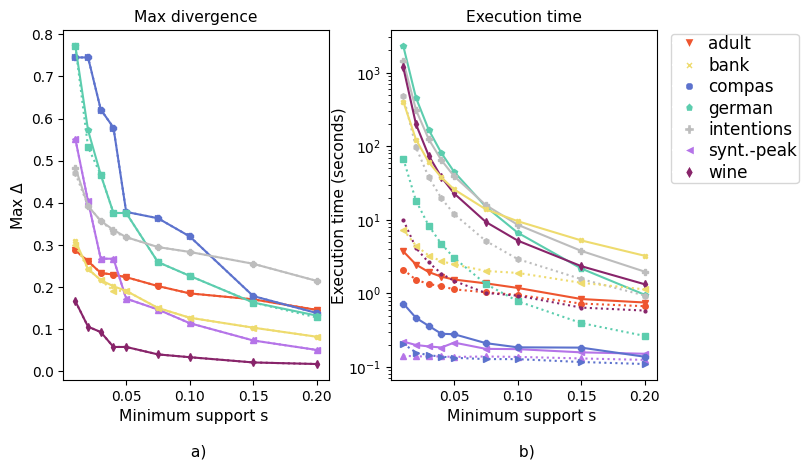

In [44]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D 

info_dicts = info_plot

marker=True
limit= None#(0, None)
nameFig=""
colorMap="tab10"

labelSize = 11.2
legendSize=12.2

markersize=4
linewidth=1.5
outside=False
titleLegend=""
tickF=False

saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel1 = "Minimum support s \n\n a)"
xlabel2 = "Minimum support s \n \n b)"
ylabel1 = "Max $\\Delta$"
ylabel2 = f"Execution time (seconds)"
title1 = f"Max divergence"
title2 = f"Execution time"

import matplotlib.pyplot as plt
import numpy as np

outside = True

if outside:
    size_fig = (7.9, 4.5) #(7.8, 4.5)
else:
    size_fig = (6.8, 4.5)


# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size_fig, dpi=100, constrained_layout = True)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}
MARKER_BASE = '*'

MARKERS[13] = "<"

markers = {}
m_i = 0
for label_name in info_dicts:
    if marker:
        if abbreviateValue('base', abbreviations) in label_name:
            marker_i = MARKER_BASE

        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_BASE:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i

for ax, info_dicts in [(ax1, info_plot_div), (ax2, info_plot_time)]:

    
    for e, (label_name, info_dict) in enumerate(info_dicts.items()):
        if 'base' in label_name:
            continue
            
        ax.plot(
                list(info_dict.keys()),
                list(info_dict.values()),
                label=label_name,
                marker=markers[label_name] if marker else None,
                linewidth=linewidth,
                markersize=(markersize if markers[label_name]!='X' else markersize*0.8) if marker else None,
                color=colors[e],
                linestyle=linestyle[label_name],
            )

import cycler


if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

ax1.set_xlabel(xlabel1, fontsize=labelSize)
ax2.set_xlabel(xlabel2, fontsize=labelSize)
ax1.set_ylabel(ylabel1, fontsize=labelSize)
ax2.set_ylabel(ylabel2, fontsize=labelSize, labelpad=1)
ax1.set_title(title1, fontsize=labelSize)
ax2.set_title(title2, fontsize=labelSize)


ax2.yaxis.labelpad = 1

ax2.yaxis.tickspad = 1

yscale="log"


plt.xscale(xscale)
if not kformat:
    ax2.set_yscale(yscale)
    
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles + handles2
labels = labels + labels2



idxs_sorted = np.argsort(labels)

idxs = [i for i in idxs_sorted if abbreviateValue('divergence_criterion', abbreviations) in labels[i] and  abbreviateValue('pruned', abbreviations) not in labels[i]]

legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Line',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7 )
                      for i in idxs]

labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')[1:] for i in idxs]


idxs = [i for i in range(len(labels)) if (i+1)== len(labels) or labels[i]!=labels[i+1] ]

labels = [labels[i] for i in idxs]
legend_handles = [legend_handles[i] for i in idxs]
"""


i = idxs[0]
legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'white', markersize=handles[i]._markersize*2.5))


legend_handles.append(Line2D([0], [0], marker=MARKER_BASE, color='w', linestyle='-.',
                              markerfacecolor = 'black', markersize=handles[i]._markersize*2.5))


labels.append("")

labels.append(r'base (---)')
"""


outside = True

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        labelspacing=0.2,
        columnspacing=0.2,
        fontsize=5,
        title_fontsize=5,
        borderaxespad = 0.2,
               borderpad = 0.1,
               handletextpad = 0.1
    )
else:
    for ax in [ax1, ax2]:
        ax.legend(handles = legend_handles, labels = labels,
            prop={"size": legendSize},
            title=titleLegend,
            fontsize=legendSize,
            title_fontsize=legendSize,
            labelspacing=0.2,
            columnspacing=0.2,
            borderpad=borderpad,
        ) 

    
if outside:
    outside_str = '_outside'
else:
    outside_str = ''
nameFig = os.path.join(output_fig_dir, f'heuristic_comparison_vs_overall_div_time{outside_str}.pdf') 
if saveFig:
    fig.tight_layout(pad = 0.03)
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

In [46]:
nameFig

'./output_results_01_05/figures/comparisons/heuristic_comparison_vs_overall_div_time_outside.pdf'